In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

In [3]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [4]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

## Using OCC+SMOTE+CC Samples

### Getting Data

In [5]:
res = pd.read_csv('../Outputs/resampled.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [6]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [7]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 10, 500),
        'max_depth':trial.suggest_int('max_depth', 1, 10), 
    }
    
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_prob)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [8]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

[I 2024-06-06 21:46:40,595] A new study created in memory with name: no-name-a8d57ab8-4762-4316-b065-31776a40155c
[I 2024-06-06 21:48:46,172] Trial 0 finished with value: 0.6357744850679072 and parameters: {'n_estimators': 258, 'max_depth': 9}. Best is trial 0 with value: 0.6357744850679072.
[I 2024-06-06 21:51:43,215] Trial 1 finished with value: 0.6327832009266902 and parameters: {'n_estimators': 414, 'max_depth': 10}. Best is trial 0 with value: 0.6357744850679072.
[I 2024-06-06 21:52:01,912] Trial 2 finished with value: 0.6387712327418025 and parameters: {'n_estimators': 89, 'max_depth': 5}. Best is trial 2 with value: 0.6387712327418025.
[I 2024-06-06 21:52:07,064] Trial 3 finished with value: 0.6181875961394161 and parameters: {'n_estimators': 81, 'max_depth': 1}. Best is trial 2 with value: 0.6387712327418025.
[I 2024-06-06 21:52:14,021] Trial 4 finished with value: 0.635250630768365 and parameters: {'n_estimators': 33, 'max_depth': 5}. Best is trial 2 with value: 0.638771232741

In [10]:
study.best_params

{'n_estimators': 14, 'max_depth': 6}

In [11]:
rf_model = RandomForestClassifier(**study.best_params, random_state=42)
rf_model.fit(X_res, y_res) 

RandomForestClassifier(max_depth=6, n_estimators=14, random_state=42)

### Making Predictions

In [12]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

### Ploting and Metrics

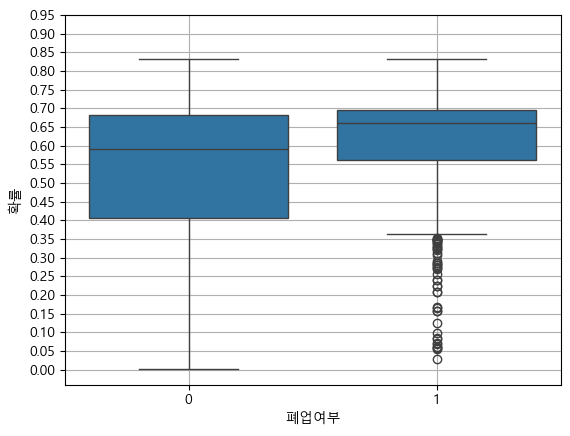

In [13]:
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp)
plt.yticks(np.arange(0, 1, 0.05))
plt.grid(True)
plt.show()

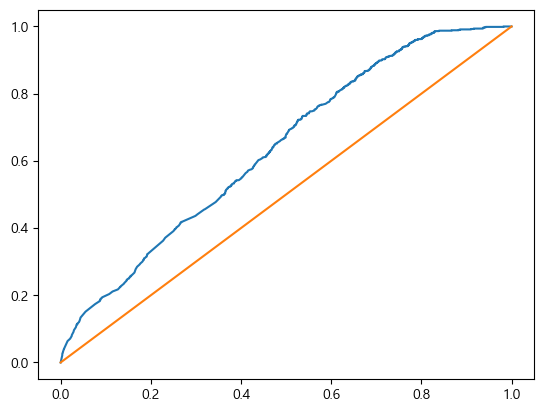

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='roc')
plt.plot([0, 1], [0, 1])

In [15]:
threshold = 0.62
y_pred = (y_pred_prob >= threshold).astype('int')

In [17]:
print("0-1 proportion at test set :", list(y_test.value_counts()))
print("accuracy :", accuracy_score(y_test, y_pred))
print("precisoin :", precision_score(y_test, y_pred))
print("recall :", recall_score(y_test, y_pred))
print("f1 :", f1_score(y_test, y_pred))
print("roc score ", roc_auc_score(y_test, y_pred_prob))

0-1 proportion at test set : [53308, 800]
accuracy : 0.5441154727581873
precisoin : 0.019875276604304968
recall : 0.6175
f1 : 0.03851101149873319
roc score  0.6362962524386584


`roc score` of using SMOTE : $0.630734845145194$

<Axes: >

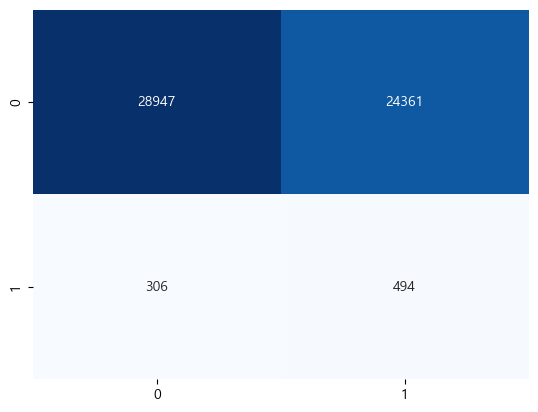

In [18]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cbar = False, annot=True, cmap = 'Blues', fmt='g')

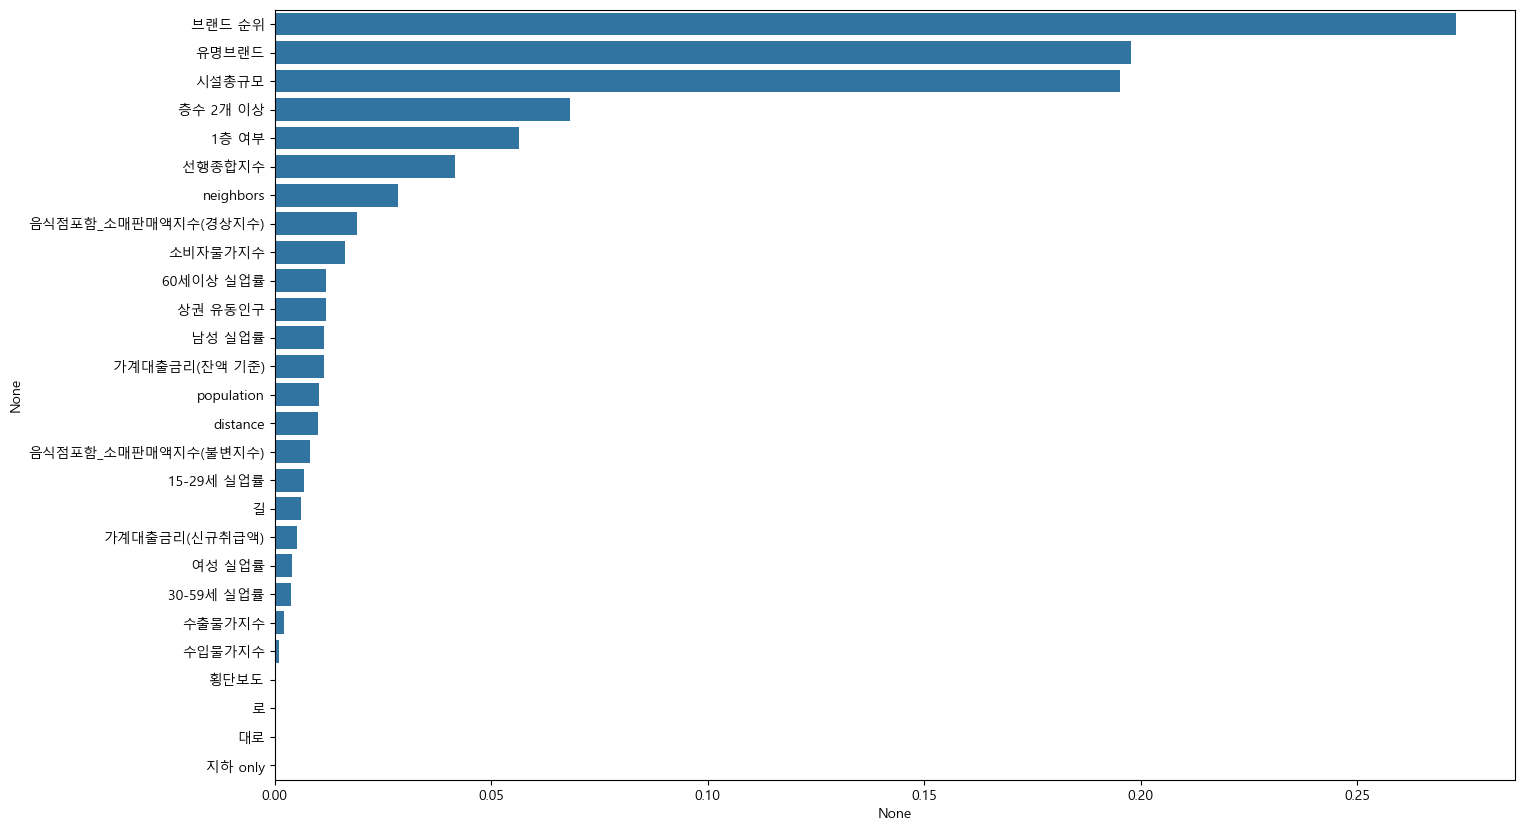

In [19]:
## Feature Importance
ser = pd.Series(rf_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()

---

## Using SMOTETomek

### Getting Data

In [5]:
res = pd.read_csv('../Outputs/resampled_smt.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set_smt.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [6]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [ ]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 10, 500),
        'max_depth':trial.suggest_int('max_depth', 1, 10)
    }
    
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred = rf_model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

In [ ]:
study.best_params

In [13]:
rf_model = RandomForestClassifier(max_depth=6, n_estimators=14, random_state=42)
rf_model.fit(X_res, y_res)

RandomForestClassifier(max_depth=6, n_estimators=14, random_state=42)

### Making Predictions

In [14]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

### Ploting and Metrics

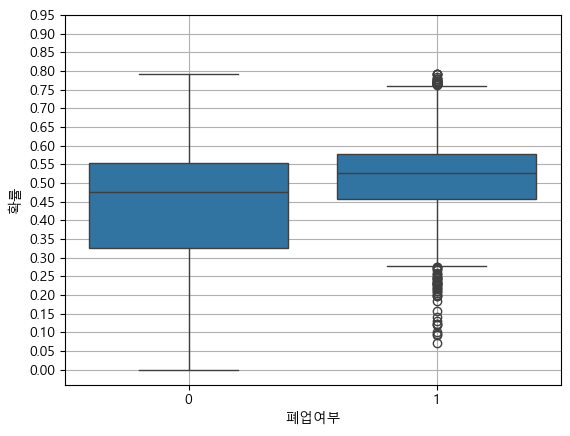

In [15]:
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp)
plt.yticks(np.arange(0, 1, 0.05))
plt.grid(True)
plt.show()

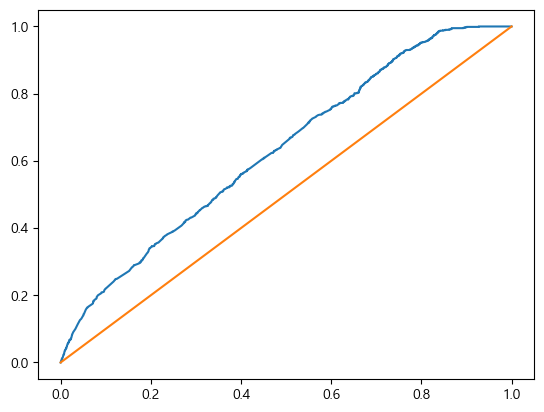

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='roc')
plt.plot([0, 1], [0, 1])

In [17]:
print("0-1 proportion at test set :", list(y_test.value_counts()))
print("accuracy :", accuracy_score(y_test, y_pred))
print("precisoin :", precision_score(y_test, y_pred))
print("recall :", recall_score(y_test, y_pred))
print("f1 :", f1_score(y_test, y_pred))
print("roc score ", roc_auc_score(y_test, y_pred_prob))

0-1 proportion at test set : [53308, 800]
accuracy : 0.5980261698824573
precisoin : 0.020551080190406443
recall : 0.56125
f1 : 0.03965030024726245
roc score  0.630734845145194


<Axes: >

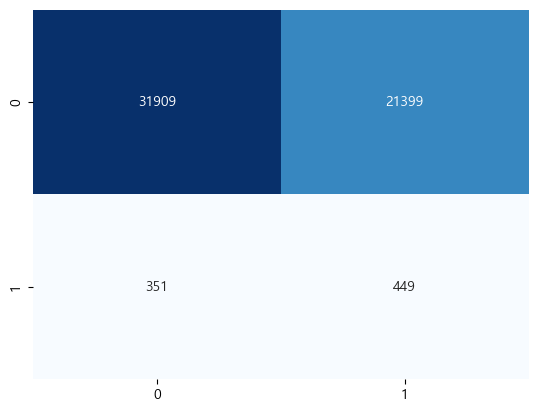

In [18]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cbar = False, annot=True, cmap = 'Blues', fmt='g')

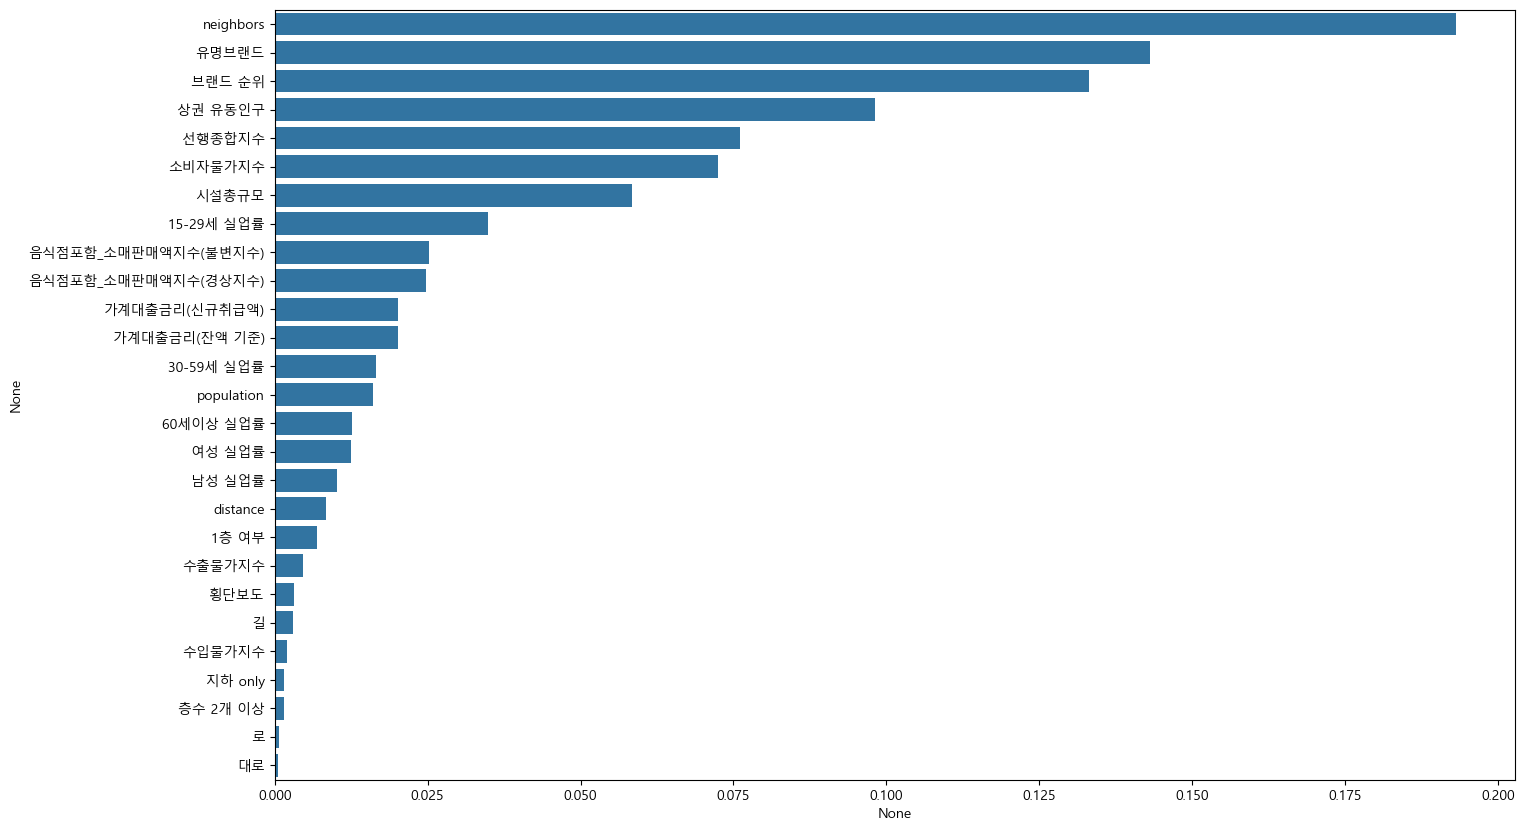

In [12]:
## Feature Importance
ser = pd.Series(rf_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()